Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded: 1320 training samples, 330 testing samples
Classes: ['Bear', 'Bobcat', 'Deer', 'Fox', 'Horse', 'Lion', 'Mouse', 'Racoon', 'Squirrel', 'Wolf']
Epoch 1/50, Loss: 179.4501, Val Accuracy: 0.3121
Best model saved with accuracy: 0.3121
Epoch 2/50, Loss: 163.6058, Val Accuracy: 0.3970
Best model saved with accuracy: 0.3970
Epoch 3/50, Loss: 152.1136, Val Accuracy: 0.4364
Best model saved with accuracy: 0.4364
Epoch 4/50, Loss: 137.6814, Val Accuracy: 0.4455
Best model saved with accuracy: 0.4455
Epoch 5/50, Loss: 129.5215, Val Accuracy: 0.4455
Epoch 6/50, Loss: 119.7954, Val Accuracy: 0.5061
Best model saved with accuracy: 0.5061
Epoch 7/50, Loss: 111.7861, Val Accuracy: 0.5455
Best model saved with accuracy: 0.5455
Epoch 8/50, Loss: 103.5469, Val Accuracy: 0.5727
Best model saved with accuracy: 0.5727
Epoch 9/50, Loss: 98.1261, Val Accuracy: 0.6121


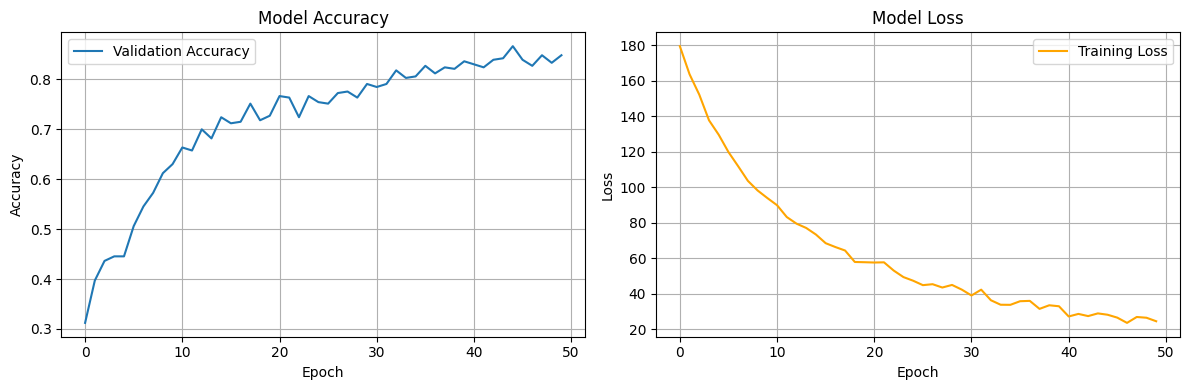

Predicted class: Lion with confidence: 1.00


In [1]:
# Install necessary packages
# !pip install torch torchvision matplotlib opencv-python scikit-learn

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os, cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split


# Paths and parameters
dataset_path = "/content/drive/MyDrive/footprints"
test_image_path = "/content/drive/MyDrive/test_fp/lion_1.jpg"
model_path = "/content/drive/MyDrive/best_footprint.pth"
img_size = 128
num_classes = 10
batch_size = 16
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define class labels
class_labels = sorted(os.listdir(dataset_path))
label_to_index = {label: idx for idx, label in enumerate(class_labels)}

# Image transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
])

# Custom Dataset
class FootprintDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        for label in class_labels:
            folder = os.path.join(root_dir, label)
            if os.path.isdir(folder):
                for file in os.listdir(folder):
                    self.samples.append((os.path.join(folder, file), label_to_index[label]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Image not found: {img_path}")
        if self.transform:
            img = self.transform(img)
        return img, label

# Load dataset
dataset = FootprintDataset(dataset_path, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print(f"Dataset loaded: {train_size} training samples, {test_size} testing samples")
print("Classes:", class_labels)

# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * (img_size//8) * (img_size//8), 512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Initialize model
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop with history tracking
train_losses = []
val_accuracies = []
best_accuracy = 0.0

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss)

    # Evaluation
    model.eval()
    correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (predicted == labels).sum().item()

    accuracy = correct / len(test_set)
    val_accuracies.append(accuracy)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}, Val Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), model_path)
        print(f"Best model saved with accuracy: {accuracy:.4f}")

# Load best model
model.load_state_dict(torch.load(model_path))
model.eval()

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_labels))

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Prediction function
def predict_footprint(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Image not found.")
        return None, None

    img = cv2.resize(img, (img_size, img_size))
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        probs = F.softmax(output, dim=1)
        predicted_idx = torch.argmax(probs).item()
        confidence = probs[0][predicted_idx].item()

    return class_labels[predicted_idx], confidence

# Test on a sample image
def predict_from_image(image_file):
    predicted_label, confidence = predict_footprint(image_file)
    if predicted_label is not None:
        print(f"Predicted class: {predicted_label} with confidence: {confidence:.2f}")

# Run prediction
predict_from_image(test_image_path)
